In [1]:
import pandas as pd
import findspark
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import time

# Бібліотеки для PySpark
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import PCA


In [2]:
# Ініціалізація findspark для використання Spark
findspark.init()

In [3]:
# **Вступ**

# У цьому проекті ми аналізуємо публічний набір даних подій електронної комерції за жовтень та листопад 2019 року.
# Дані містять понад 100 мільйонів записів про взаємодії користувачів з платформою електронної комерції,
# включаючи перегляди товарів, додавання до кошика та покупки.

# **Обґрунтування використання "Великих Даних":**

# - **Обсяг (Volume)**: Дані містять приблизно 110 мільйонів рядків та займають близько 8 ГБ у форматі CSV.
# - **Швидкість (Velocity)**: Дані збираються з високою частотою, що надає детальні уявлення про поведінку користувачів.
# - **Різноманітність (Variety)**: Дані включають різні типи, такі як часові мітки, категоріальні та числові змінні.
# - **Обмеження обробки**: Обробка такого великого обсягу даних на одній машині є неефективною та повільною.
#   Тому для ефективної обробки даних використовується розподілене обчислення з Apache Spark.

# Ці характеристики відповідають трьом "V" (Volume, Velocity, Variety) Великих Даних,
# що обґрунтовує їх класифікацію як Великі Дані.

# **1. Збір та підготовка даних**

# Завантаження даних за жовтень та листопад 2019 року
df_oct = pd.read_csv('2019-Oct.csv')
df_nov = pd.read_csv('2019-Nov.csv')

# Об'єднання наборів даних в один DataFrame
df = pd.concat([df_oct, df_nov], ignore_index=True)

# Звільнення пам'яті від окремих місяців
del df_oct, df_nov

In [4]:
# Початкова інформація про дані
print("Початкова інформація про дані:")
print(df.info())

# Приклад перших 5 рядків
print("\nПриклад даних:")
print(df.head())

# Перевірка на пропущені значення
print("\nПропущені значення у кожному стовпці:")
print(df.isnull().sum())

# Базова статистика
print("\nСтатистичний огляд:")
print(df.describe())

Початкова інформація про дані:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109950743 entries, 0 to 109950742
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 7.4+ GB
None

Приклад даних:
                event_time event_type  product_id          category_id  \
0  2019-10-01 00:00:00 UTC       view    44600062  2103807459595387724   
1  2019-10-01 00:00:00 UTC       view     3900821  2053013552326770905   
2  2019-10-01 00:00:01 UTC       view    17200506  2053013559792632471   
3  2019-10-01 00:00:01 UTC       view     1307067  2053013558920217191   
4  2019-10-01 00:00:04 UTC       view     1004237  2053013555631882655   

                 

In [5]:
# **Очищення та попередня обробка даних**

# Видалення записів з відсутніми або некоректними значеннями 'price'
df = df.dropna(subset=['price'])      # Видалення записів з відсутніми цінами
df = df[df['price'] > 0]              # Видалення записів з ціною <= 0

# Пояснення: Продукти з відсутніми або некоректними цінами не є корисними для аналізу продажів та доходів.

# Заповнення пропусків у 'category_code' та 'brand' значенням 'unknown'
df['category_code'].fillna('unknown', inplace=True)
df['brand'].fillna('unknown', inplace=True)

# Пояснення: Заповнення пропущених значень дозволяє зберегти ці записи для аналізу без введення упереджень.

# Видалення записів з відсутніми 'user_session'
df.dropna(subset=['user_session'], inplace=True)

# Пояснення: 'user_session' важлива для відстеження поведінки користувачів; відсутні значення ускладнюють аналіз сесій.

# Видалення дублікатів
df = df.drop_duplicates()

# Пояснення: Дублікати можуть спотворити результати аналізу, переоцінюючи певні події.

# Перетворення категоріального 'event_type' у числові значення
df['event_type'] = df['event_type'].map({'view': 0, 'cart': 1, 'purchase': 2})

# Пояснення: Числове кодування категоріальних змінних необхідне для моделей машинного навчання.

# Витяг додаткових часових ознак
df['event_time'] = pd.to_datetime(df['event_time'])
df['hour'] = df['event_time'].dt.hour
df['day_of_week'] = df['event_time'].dt.dayofweek
df['day'] = df['event_time'].dt.day
df['month'] = df['event_time'].dt.month
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >=5 else 0)

# Пояснення: Часові ознаки можуть виявити закономірності в поведінці користувачів, пов'язані з часом дня або днями тижня.


/var/folders/7h/3w921_vx6tngbk9tj6c3x70h0000gn/T/ipykernel_73670/857046149.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['category_code'].fillna('unknown', inplace=True)
/var/folders/7h/3w921_vx6tngbk9tj6c3x70h0000gn/T/ipykernel_73670/857046149.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

In [6]:
# Нормалізація стовпця 'price'
scaler = StandardScaler()
df['price_normalized'] = scaler.fit_transform(df[['price']])

# Пояснення: Нормалізація допомагає привести всі ознаки до схожого масштабу, що важливо для алгоритмів кластеризації.


In [7]:
# **Зберігання даних**

# Збереження очищених даних у форматі Parquet для ефективного зберігання та швидшої обробки з Spark.

# Пояснення:
# - Parquet - це колонний формат зберігання, який забезпечує ефективне стиснення даних та схеми кодування.
# - Він оптимізований для продуктивності запитів, особливо для великих наборів даних.
# - Він добре інтегрується з Apache Spark, що дозволяє ефективну розподілену обробку.

df.to_parquet('cleaned_ecommerce_data.parquet', index=False, engine='pyarrow', coerce_timestamps='ms', allow_truncated_timestamps=True)


Кількість подій за типами:
event_type
0    104079641
1      3823991
2      1659703
Name: count, dtype: int64


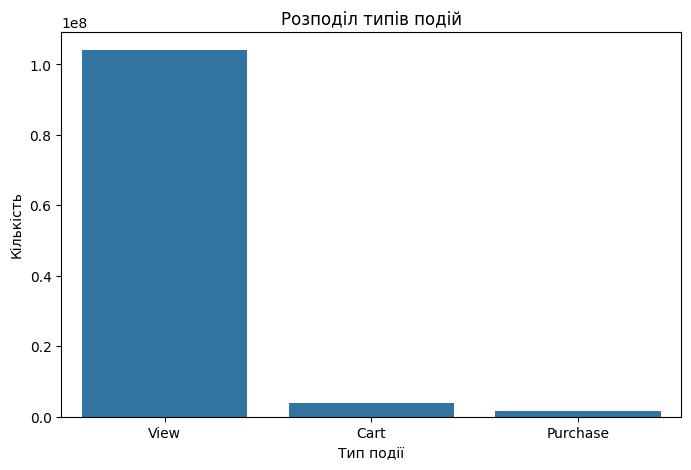

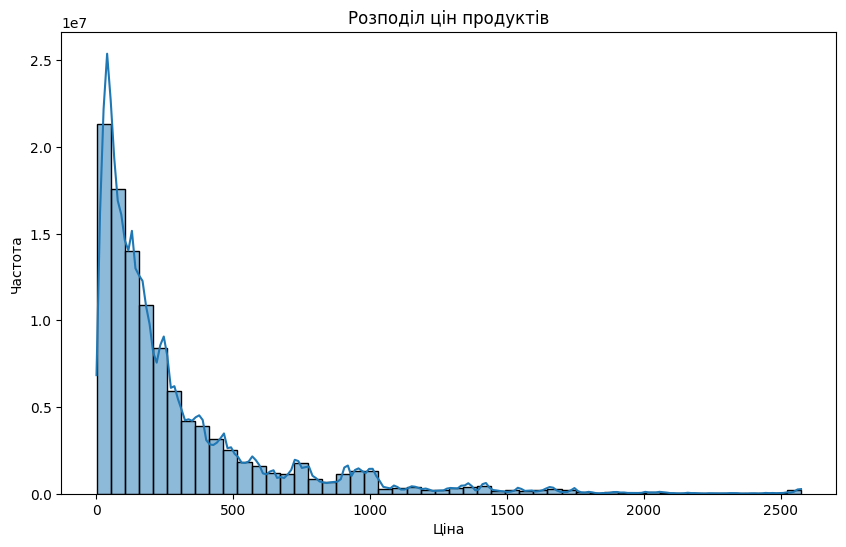

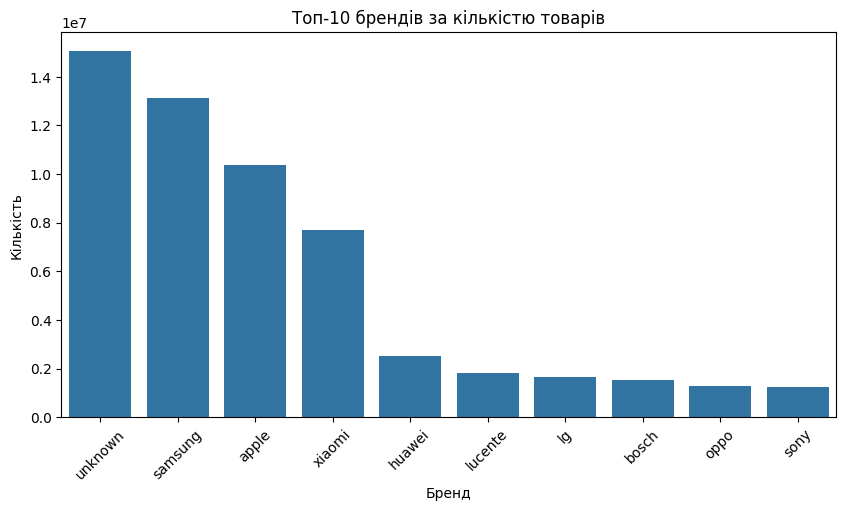

In [8]:
# **2. Аналіз та моделювання**

# **Дослідницький аналіз даних (EDA)**

# Аналіз типів подій
print("\nКількість подій за типами:")
print(df['event_type'].value_counts())

# Візуалізація розподілу типів подій
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='event_type', order=sorted(df['event_type'].unique()))
plt.title('Розподіл типів подій')
plt.xlabel('Тип події')
plt.ylabel('Кількість')
plt.xticks([0, 1, 2], ['View', 'Cart', 'Purchase'])
plt.show()

# Візуалізація розподілу цін
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Розподіл цін продуктів')
plt.xlabel('Ціна')
plt.ylabel('Частота')
plt.show()

# Топ-10 брендів за кількістю товарів
top_brands = df['brand'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_brands.index, y=top_brands.values)
plt.title('Топ-10 брендів за кількістю товарів')
plt.xlabel('Бренд')
plt.ylabel('Кількість')
plt.xticks(rotation=45)
plt.show()

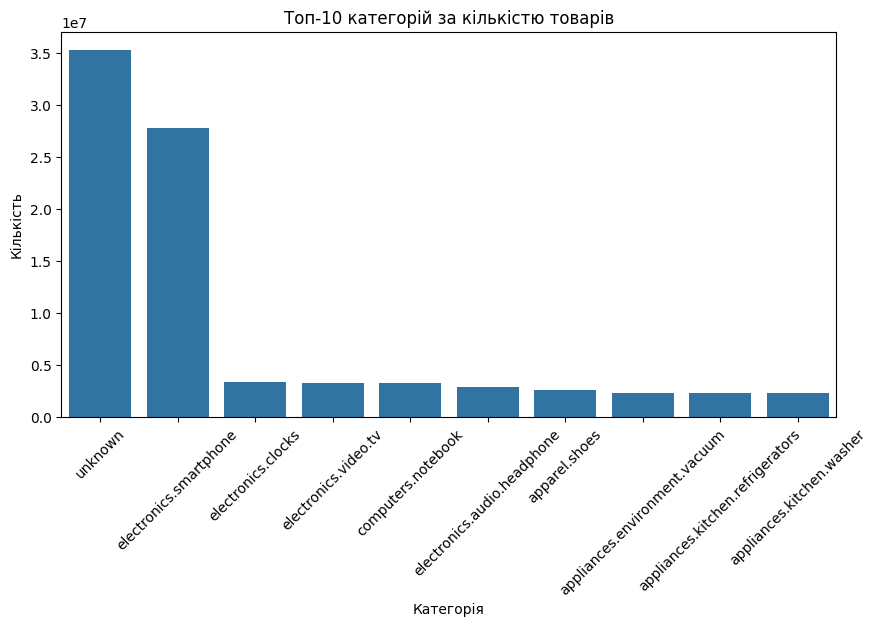

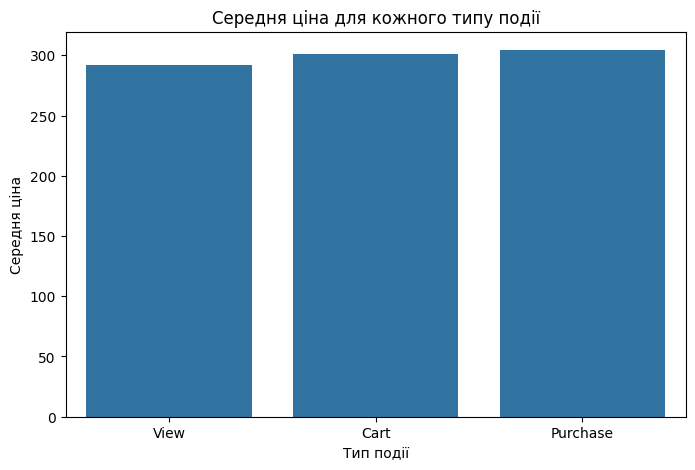

In [9]:
# Топ-10 категорій за кількістю товарів
top_categories = df['category_code'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_categories.index, y=top_categories.values)
plt.title('Топ-10 категорій за кількістю товарів')
plt.xlabel('Категорія')
plt.ylabel('Кількість')
plt.xticks(rotation=45)
plt.show()

# Середня ціна для кожного типу події
avg_price_per_event = df.groupby('event_type')['price'].mean()
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_price_per_event.index, y=avg_price_per_event.values)
plt.title('Середня ціна для кожного типу події')
plt.xlabel('Тип події')
plt.ylabel('Середня ціна')
plt.xticks([0, 1, 2], ['View', 'Cart', 'Purchase'])
plt.show()

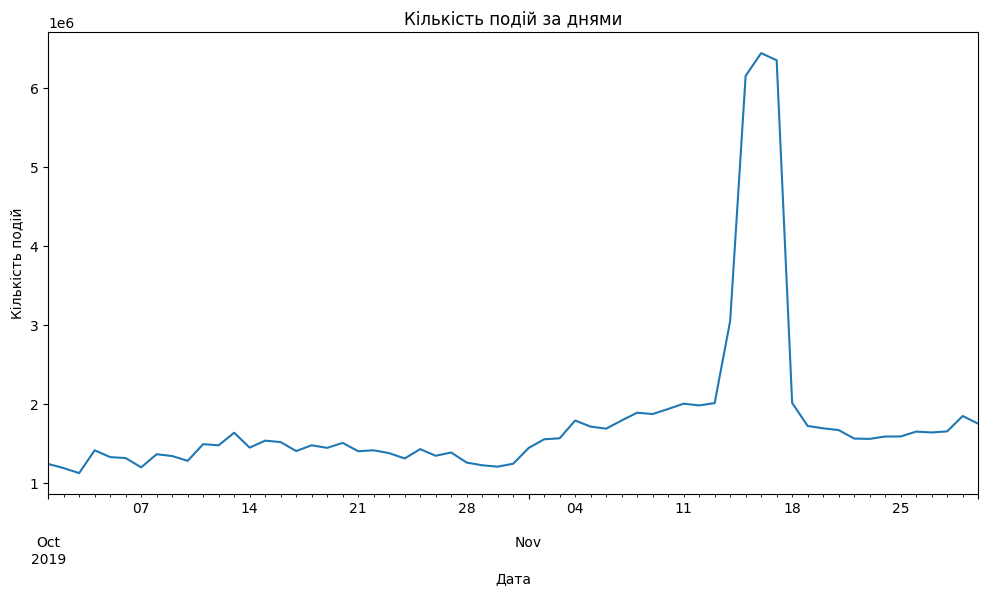

In [10]:
# Щоденна кількость подій
df.set_index('event_time', inplace=True)
daily_counts = df.resample('D').size()
plt.figure(figsize=(12, 6))
daily_counts.plot()
plt.title('Кількість подій за днями')
plt.xlabel('Дата')
plt.ylabel('Кількість подій')
plt.show()

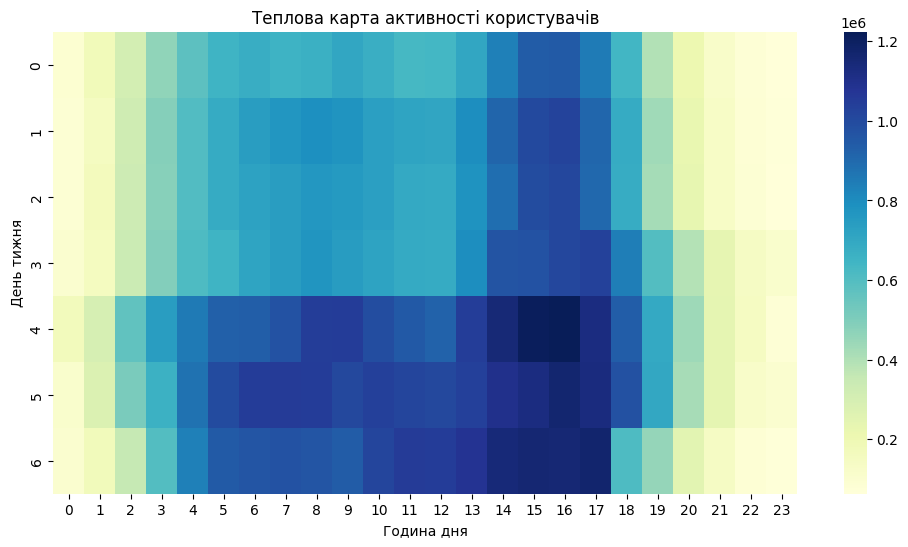

In [11]:
# Теплова карта активності користувачів за днем тижня та годиною
activity = df.groupby(['day_of_week', 'hour']).size().unstack()
plt.figure(figsize=(12, 6))
sns.heatmap(activity, cmap="YlGnBu")
plt.title('Теплова карта активності користувачів')
plt.xlabel('Година дня')
plt.ylabel('День тижня')
plt.show()

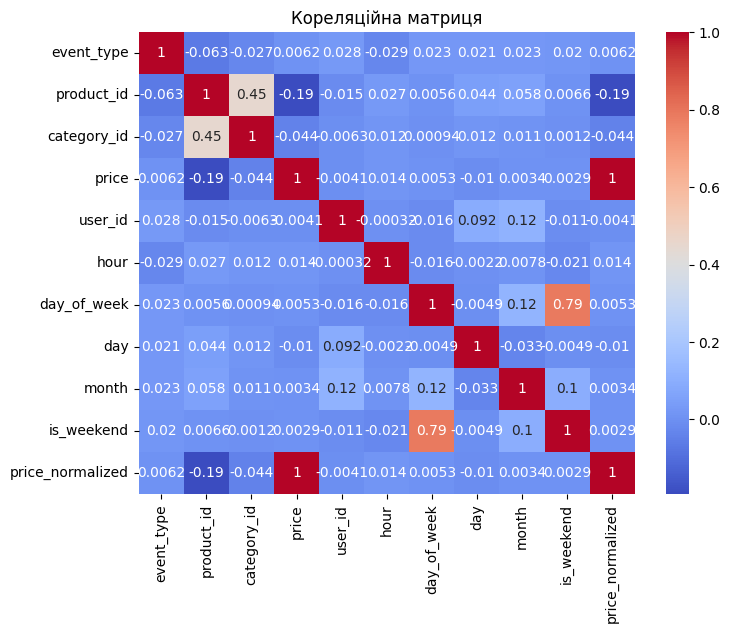

In [12]:
# Вибір числових стовпців для кореляційного аналізу
numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Кореляційна матриця')
plt.show()

In [13]:

# **Вибір та обґрунтування методів аналізу**

# Мета:

# - **Сегментація клієнтів**: Групування користувачів на основі їх поведінки для виявлення шаблонів та налаштування маркетингових стратегій.
# - **Сегментація продуктів**: Групування продуктів для розуміння категорій або брендів, які мають схожу продуктивність.

# Обґрунтування вибору KMeans кластеризації:

# - **Простота та ефективність**: KMeans є обчислювально ефективним, що важливо для великих наборів даних.
# - **Інтерпретованість**: Алгоритм надає чіткі центри кластерів, що полегшує інтерпретацію сегментів.
# - **Припущення про форму кластерів**: KMeans передбачає сферичні кластери, що прийнятно для цього аналізу.

# Очікувані результати:

# - Виявлення різних шаблонів поведінки користувачів.
# - Виявлення груп продуктів, з якими взаємодіють схожим чином.
# - Надання інформації для персоналізованих рекомендацій, цільової реклами та управління запасами.

# **Оптимізація та налаштування методів аналізу**

# Визначення оптимальної кількості кластерів (k) за допомогою методу "ліктя" та аналізу силуетів.

# **Реалізація методів**

# Ініціалізація Spark Session
spark = SparkSession.builder.appName("E-commerce Analysis").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# Завантаження очищених даних у Spark DataFrame
spark_df = spark.read.parquet('cleaned_ecommerce_data.parquet')

# Перетворення типів даних
spark_df = spark_df.withColumn("event_type", spark_df["event_type"].cast(IntegerType()))
spark_df = spark_df.withColumn("price_normalized", spark_df["price_normalized"].cast(DoubleType()))
spark_df = spark_df.withColumn("hour", spark_df["hour"].cast(IntegerType()))
spark_df = spark_df.withColumn("day_of_week", spark_df["day_of_week"].cast(IntegerType()))
spark_df = spark_df.withColumn("day", spark_df["day"].cast(IntegerType()))
spark_df = spark_df.withColumn("month", spark_df["month"].cast(IntegerType()))
spark_df = spark_df.withColumn("is_weekend", spark_df["is_weekend"].cast(IntegerType()))

24/11/10 20:21:33 WARN Utils: Your hostname, MacBook-Pro-Nazarii.local resolves to a loopback address: 127.0.0.1; using 192.168.0.101 instead (on interface en0)
24/11/10 20:21:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/10 20:21:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [14]:

# Кодування категоріальних змінних за допомогою StringIndexer
category_indexer = StringIndexer(inputCol='category_code', outputCol='category_index')
category_model = category_indexer.fit(spark_df)
spark_df = category_model.transform(spark_df)

brand_indexer = StringIndexer(inputCol='brand', outputCol='brand_index')
brand_model = brand_indexer.fit(spark_df)
spark_df = brand_model.transform(spark_df)

In [15]:
# Вибір вхідних стовпців для моделі
input_cols = ['event_type', 'price_normalized', 'hour', 'day_of_week', 'category_index', 'brand_index']

# Створення вектора ознак
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
assembled_data = assembler.transform(spark_df)

In [16]:
# Визначення оптимального k за допомогою методу "ліктя" та аналізу силуетів
cost = []
silhouette_scores = []
k_values = range(2, 10)  # Можна змінити діапазон за потреби

for k in k_values:
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(assembled_data.select('features'))
    predictions = model.transform(assembled_data)
    
    # Обчислення WSSSE (Within Set Sum of Squared Errors)
    wssse = model.summary.trainingCost
    cost.append(wssse)
    
    # Обчислення коефіцієнта силуету
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)
    
    print(f"Для k = {k}, WSSSE = {wssse}, Коефіцієнт силуету = {silhouette}")

Для k = 2, WSSSE = 2854126575104.7427, Коефіцієнт силуету = 0.9484290506540541


Для k = 3, WSSSE = 1383324489413.967, Коефіцієнт силуету = 0.9241904869751246


Для k = 4, WSSSE = 822408660563.5249, Коефіцієнт силуету = 0.905294023944716


Для k = 5, WSSSE = 557875812733.0468, Коефіцієнт силуету = 0.8734120276382928


Для k = 6, WSSSE = 390413820269.22675, Коефіцієнт силуету = 0.8696895264226212


Для k = 7, WSSSE = 298186740586.3318, Коефіцієнт силуету = 0.8629549514683708


Для k = 8, WSSSE = 243118054483.17154, Коефіцієнт силуету = 0.8626926770580791


Для k = 9, WSSSE = 215181056367.9993, Коефіцієнт силуету = 0.8619632545073613


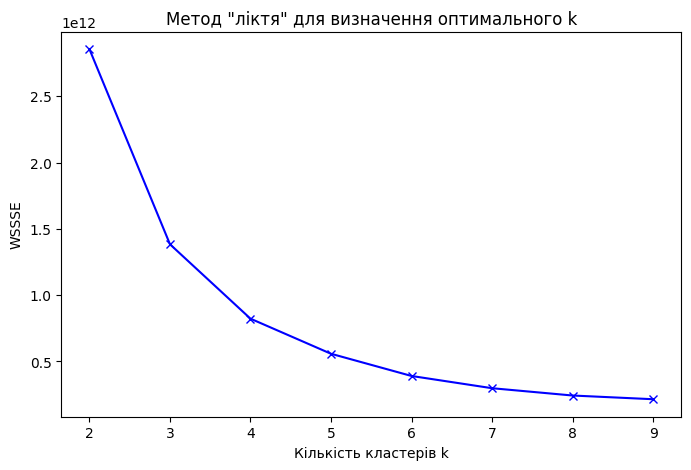

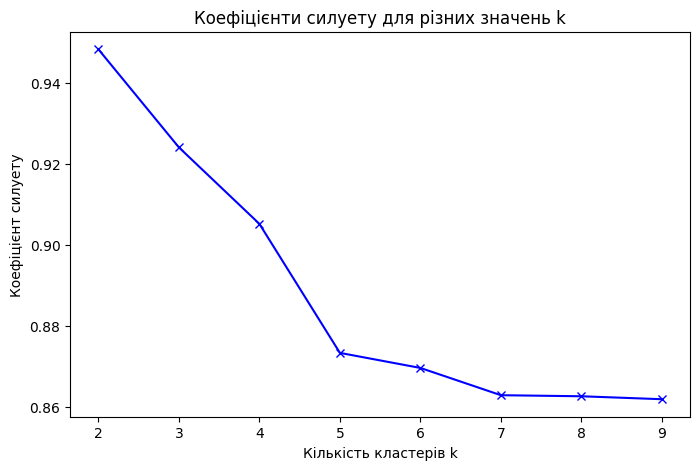

In [17]:
# Візуалізація WSSSE (метод "ліктя")
plt.figure(figsize=(8, 5))
plt.plot(k_values, cost, 'bx-')
plt.xlabel('Кількість кластерів k')
plt.ylabel('WSSSE')
plt.title('Метод "ліктя" для визначення оптимального k')
plt.show()

# Візуалізація коефіцієнтів силуету
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, 'bx-')
plt.xlabel('Кількість кластерів k')
plt.ylabel('Коефіцієнт силуету')
plt.title('Коефіцієнти силуету для різних значень k')
plt.show()

In [18]:
# Вибір оптимального k на основі максимального коефіцієнта силуету
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]
print(f"Оптимальна кількість кластерів: {optimal_k}")

Оптимальна кількість кластерів: 2


In [19]:
# Навчання моделі KMeans з оптимальним k

kmeans = KMeans().setK(optimal_k).setSeed(1)
model = kmeans.fit(assembled_data.select('features'))

# Отримання передбачень кластерів
clusters = model.transform(assembled_data)

In [20]:
# Оцінка моделі
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(clusters)
print(f"Коефіцієнт силуету з квадратною евклідовою відстанню: {silhouette}")

Коефіцієнт силуету з квадратною евклідовою відстанню: 0.9484290506540541


In [21]:
# **3. Візуалізація та презентація результатів**

# Аналіз результатів кластеризації

# Підрахунок кількості записів у кожному кластері
cluster_counts = clusters.groupBy('prediction').count().orderBy('prediction')
cluster_counts.show()

# Огляд центрів кластерів
centers = model.clusterCenters()
print("Координати центрів кластерів:")
for idx, center in enumerate(centers):
    print(f"Кластер {idx}: {center}")

+----------+---------+
|prediction|    count|
+----------+---------+
|         0|104150057|
|         1|  5413278|
+----------+---------+

Координати центрів кластерів:
Кластер 0: [6.70919940e-02 1.26099246e-02 1.12436209e+01 3.26250402e+00
 8.28373596e+00 5.56852788e+01]
Кластер 1: [ 2.87740626e-02 -2.42611661e-01  1.15814948e+01  3.24530848e+00
  1.66197282e+01  1.12798496e+03]


In [22]:
# Конвертація центрів кластерів у DataFrame для інтерпретації
centers_df = pd.DataFrame(centers, columns=input_cols)
centers_df['cluster'] = centers_df.index

# Інтерпретація кластерів
for idx, row in centers_df.iterrows():
    print(f"\nКластер {idx}:")
    print(f"- Середній тип події: {row['event_type']}")
    print(f"- Середня ціна (нормалізована): {row['price_normalized']}")
    print(f"- Середня година взаємодії: {row['hour']}")
    print(f"- Середній день тижня: {row['day_of_week']}")
    print(f"- Середній індекс категорії: {row['category_index']}")
    print(f"- Середній індекс бренду: {row['brand_index']}")


Кластер 0:
- Середній тип події: 0.06709199400630189
- Середня ціна (нормалізована): 0.012609924627995489
- Середня година взаємодії: 11.243620894033693
- Середній день тижня: 3.2625040234015428
- Середній індекс категорії: 8.283735956092661
- Середній індекс бренду: 55.68527882802791

Кластер 1:
- Середній тип події: 0.028774062592019103
- Середня ціна (нормалізована): -0.24261166132079742
- Середня година взаємодії: 11.581494798530576
- Середній день тижня: 3.2453084803699346
- Середній індекс категорії: 16.619728194266024
- Середній індекс бренду: 1127.9849566196303


In [23]:
# Приєднання оригінальних даних для аналізу кластерів
selected_columns = ['event_type', 'price_normalized', 'hour', 'day_of_week', 'category_index', 'brand_index', 'prediction']
clusters_pd = clusters.select(*selected_columns).limit(10000).toPandas()
# Інвертування індексів до оригінальних категорій
category_labels = category_model.labels
brand_labels = brand_model.labels

clusters_pd['category_code'] = clusters_pd['category_index'].apply(lambda x: category_labels[int(x)])
clusters_pd['brand'] = clusters_pd['brand_index'].apply(lambda x: brand_labels[int(x)])

# Аналіз середніх значень ознак для кожного кластера
cluster_summary = clusters_pd.groupby('prediction').mean(numeric_only=True)
print(cluster_summary)

            event_type  price_normalized      hour  day_of_week  \
prediction                                                        
0             0.034606          0.020852  1.772799          1.0   
1             0.008114         -0.295808  1.742394          1.0   

            category_index  brand_index  
prediction                               
0                 8.437046    52.752288  
1                17.640974  1103.403651  


/Users/eyr1on/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


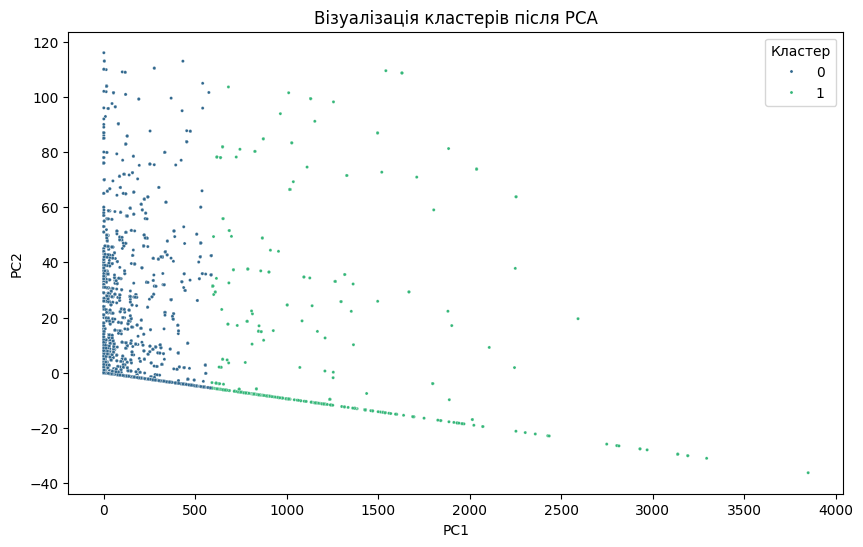

In [24]:
# Візуалізація кластерів за двома головними компонентами

# Виконання PCA для зменшення розмірності до 2 компонентів
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(clusters)
pca_result = pca_model.transform(clusters)

# Перетворення в Pandas DataFrame для візуалізації
pca_pd = pca_result.select("pcaFeatures", "prediction").limit(10000).toPandas()
pca_pd[['pc1', 'pc2']] = pd.DataFrame(pca_pd['pcaFeatures'].tolist(), index=pca_pd.index)

# Візуалізація
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pc1', y='pc2', hue='prediction', data=pca_pd, palette='viridis', s=5)
plt.title('Візуалізація кластерів після PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Кластер')
plt.show()

In [25]:
# Порівняння продуктивності: PySpark vs Pandas

# Вимірювання часу обробки в PySpark
start_time = time.time()
popular_products_spark = spark_df.groupBy('category_code').count().orderBy('count', ascending=False)
popular_products_spark.show(10)
end_time = time.time()
print(f"Час обробки в PySpark: {end_time - start_time:.2f} секунд")

# Вимірювання часу обробки в Pandas
start_time = time.time()
popular_products_pandas = df['category_code'].value_counts().head(10)
print(popular_products_pandas)
end_time = time.time()
print(f"Час обробки в Pandas: {end_time - start_time:.2f} секунд")

+--------------------+--------+
|       category_code|   count|
+--------------------+--------+
|             unknown|35250524|
|electronics.smart...|27811307|
|  electronics.clocks| 3390039|
|electronics.video.tv| 3308483|
|  computers.notebook| 3308441|
|electronics.audio...| 2911629|
|       apparel.shoes| 2630792|
|appliances.enviro...| 2325263|
|appliances.kitche...| 2310365|
|appliances.kitche...| 2266757|
+--------------------+--------+
only showing top 10 rows

Час обробки в PySpark: 1.22 секунд
category_code
unknown                             35250524
electronics.smartphone              27811307
electronics.clocks                   3390039
electronics.video.tv                 3308483
computers.notebook                   3308441
electronics.audio.headphone          2911629
apparel.shoes                        2630792
appliances.environment.vacuum        2325263
appliances.kitchen.refrigerators     2310365
appliances.kitchen.washer            2266757
Name: count, dtype: int64
Ч

In [ ]:
# **Висновки та потенційні застосування**

# Кластерний аналіз виявив різні сегменти користувачів та продуктів у даних електронної комерції.

# **Потенційні застосування:**

# - **Маркетингові стратегії**:

#   - Налаштування промоакцій та реклами для конкретних сегментів користувачів.
#   - Виявлення потенційних клієнтів з високою цінністю для цільових кампаній.

# - **Рекомендації продуктів**:

#   - Покращення системи рекомендацій, пропонуючи продукти, популярні в кластері користувача.
#   - Збільшення можливостей крос-продажів через розуміння переваг користувачів.

# - **Управління запасами**:

#   - Оптимізація рівнів запасів на основі популярності продуктів у різних кластерах.
#   - Прогнозування тенденцій попиту через аналіз поведінки кластерів з часом.

# - **Покращення користувацького досвіду**:

#   - Персоналізація інтерфейсу сайту/додатку відповідно до характеристик кластеру користувача.
#   - Впровадження функцій, які залучають користувачів у пікові періоди активності.

# **Майбутня робота:**

# - Інтеграція більш просунутих моделей машинного навчання для прогнозування поведінки користувачів.
# - Дослідження обробки даних у режимі реального часу для надання миттєвих інсайтів та рекомендацій.

# **Архітектура системи**

# **Огляд:**

# - **Джерело даних**: Сирі CSV-файли, що містять дані подій електронної комерції.
# - **Зберігання даних**: Очищені дані зберігаються у форматі Parquet для ефективного доступу.
# - **Фреймворк обробки**: Apache Spark використовується для розподіленої обробки та аналізу.
# - **Інструменти аналізу**: PySpark MLlib для задач машинного навчання; Pandas та Seaborn для візуалізації.

# **Обґрунтування вибору технологій:**

# - **Apache Spark**:

#   - **Масштабованість**: Може ефективно обробляти великі набори даних через розподілені обчислення.
#   - **Швидкість**: Обчислення в пам'яті підвищує швидкість обробки.
#   - **Універсальність**: Підтримує різні задачі обробки даних, включаючи SQL-запити, потокові дані, машинне навчання та графові обчислення.

# - **Формат Parquet**:

#   - **Колонне зберігання**: Покращує продуктивність читання для вибраних стовпців.
#   - **Стиснення**: Зменшує місце для зберігання та пропускну здатність вводу/виводу.

# - **PySpark MLlib**:

#   - **Інтеграція з Spark**: Дозволяє безшовне використання алгоритмів машинного навчання на великих наборах даних.
#   - **Продуктивність**: Оптимізований для розподілених обчислювальних середовищ.

# Така архітектура дозволяє ефективно працювати з Великими Даними, забезпечуючи масштабований та продуктивний аналіз, який неможливо здійснити на одній машині.

In [27]:
# Зупинка Spark Session
spark.stop()